# COCO dataset example

## Set Up

### Imports

In [1]:
import pathlib
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.v2.functional as TVF
from torch.utils.data import DataLoader
from torchvision import datasets, tv_tensors
from torchvision.transforms import v2 as tv_transforms
from torchvision.tv_tensors._dataset_wrapper import wrap_dataset_for_transforms_v2 as tv_wrap_dataset_for_transforms_v2
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

from torchaug import ta_tensors
from torchaug import transforms as ta_transforms
from torchaug.data.dataloader import default_collate
from torchaug.data.dataset import wrap_dataset_for_transforms_v2

### Utils functions

In [2]:
#### visualization function tools
def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 5), squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, (tv_tensors.BoundingBoxes, ta_tensors.BoundingBoxes)):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = TVF.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = TVF.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=0.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()


def uncollate_batch(batch):
    imgs = batch[0]
    targets = batch[1:][0]
    decollate_imgs = imgs.to_samples()
    for key, elems in targets.items():
        if key == "boxes":
            decollate_bbox = elems.to_samples()
        elif key == "masks":
            decollate_mask = elems.to_samples()
        elif key == "labels":
            decollate_labels = elems.to_samples()

    decollate = [
        (
            decollate_imgs[i],
            {
                "boxes": decollate_bbox[i],
                "masks": decollate_mask[i],
                "labels": decollate_labels[i],
            },
        )
        for i in range(len(decollate_imgs))
    ]

    return decollate

### Dataset creations

In [3]:
ROOT = pathlib.Path("/home/jdenize/Documents/data") / "coco"  # replace by your path
IMAGES_PATH = str(ROOT / "val2017")
ANNOTATIONS_PATH = str(ROOT / "annotations" / "instances_val2017.json")

#### Torchaug

In [4]:
torchaug_dataset = datasets.CocoDetection(IMAGES_PATH, ANNOTATIONS_PATH, transforms=ta_transforms.Resize([224, 224]))
torchaug_dataset = wrap_dataset_for_transforms_v2(torchaug_dataset, target_keys=("boxes", "labels", "masks"))
torchaug_dataloader = DataLoader(torchaug_dataset, batch_size=5, collate_fn=default_collate)

loading annotations into memory...
Done (t=0.34s)
creating index...
index created!


#### Torchvision

In [5]:
torchvision_dataset = datasets.CocoDetection(
    IMAGES_PATH, ANNOTATIONS_PATH, transforms=tv_transforms.Resize([224, 224])
)
torchvision_dataset = tv_wrap_dataset_for_transforms_v2(torchvision_dataset, target_keys=("boxes", "labels", "masks"))

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


### Transform batch

In [6]:
seed = 203  # set seed for reproducibility

#### Torchaug

In [7]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

torchaug_transform = ta_transforms.SequentialTransform(
    [
        ta_transforms.RandomHorizontalFlip(p=0.5),
        ta_transforms.ColorJitter(0.4, 0.4, 0.4, 0.2),
        ta_transforms.RandomResizedCrop(224),
    ],
    transforms_attributes_override={
        "inplace": True,
        "batch_inplace": True,
        "batch_transform": True,
        "num_chunks": 2,
        "permute_chunks": False,
    },
)

batch = next(iter(torchaug_dataloader))
torchaug_transformed_batch = torchaug_transform(batch)
torchaug_transformed_batch_uncollated = uncollate_batch(torchaug_transformed_batch)
sanitized_torchaug_batch = ta_transforms.SanitizeBoundingBoxes()(torchaug_transformed_batch)
sanitized_torchaug_batch_uncollated = uncollate_batch(sanitized_torchaug_batch)

#### Torchvision

In [8]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

batch = next(iter(torchaug_dataloader))
indices_flip = torchaug_transform.transforms[0]._get_indices_transform(5, "cpu")
params_color = torchaug_transform.transforms[1]._get_params(
    batch[0], 2, (torch.tensor([0, 1, 2]), torch.tensor([3, 4]))
)
params_crop = torchaug_transform.transforms[2]._get_params(batch[0], 2, None)
torchvision_batch = [torchvision_dataset[i] for i in range(5)]
for idx in indices_flip:
    torchvision_batch[idx] = tv_transforms.RandomHorizontalFlip(1)(torchvision_batch[idx])
for idxs, param_color in zip([[0, 1, 2], [3, 4]], params_color):
    tv_transform_color = tv_transforms.ColorJitter(0.4, 0.4, 0.4, 0.2)
    tv_transform_color._get_params = lambda x: param_color
    for i, idx in enumerate(idxs):
        tv_transform_color._get_params = lambda x: {
            "fn_idx": param_color["fn_idx"],
            "brightness_factor": float(param_color["brightness_factor"][i]),
            "contrast_factor": float(param_color["contrast_factor"][i]),
            "saturation_factor": float(param_color["saturation_factor"][i]),
            "hue_factor": float(param_color["hue_factor"][i]),
        }
        torchvision_batch[idx] = tv_transform_color(torchvision_batch[idx])
for idxs, param_crop in zip([[0, 1, 2], [3, 4]], params_crop):
    tv_transform_resized_crop = tv_transforms.RandomResizedCrop([224, 224])
    tv_transform_resized_crop._get_params = lambda x: param_crop
    for idx in idxs:
        torchvision_batch[idx] = tv_transform_resized_crop(torchvision_batch[idx])
sanitized_torchvision_batch = [tv_transforms.SanitizeBoundingBoxes()(img) for img in torchvision_batch]

## Visualization

### Torchaug

/home/jdenize/miniconda3/envs/torchaug/lib/python3.11/site-packages/torchvision/utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")
/home/jdenize/miniconda3/envs/torchaug/lib/python3.11/site-packages/torchvision/utils.py:303: UserWarning: masks doesn't contain any mask. No mask was drawn
  warnings.warn("masks doesn't contain any mask. No mask was drawn")


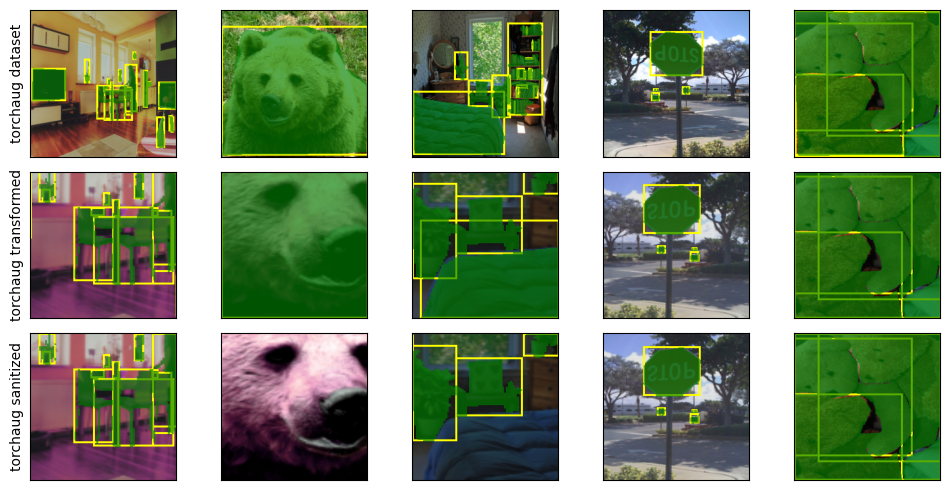

In [9]:
plot(
    [
        [torchaug_dataset[i] for i in range(5)],
        torchaug_transformed_batch_uncollated,
        sanitized_torchaug_batch_uncollated,
    ],
    row_title=["torchaug dataset", "torchaug transformed", "torchaug sanitized"],
)

### Torchvision

/home/jdenize/miniconda3/envs/torchaug/lib/python3.11/site-packages/torchvision/utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")
/home/jdenize/miniconda3/envs/torchaug/lib/python3.11/site-packages/torchvision/utils.py:303: UserWarning: masks doesn't contain any mask. No mask was drawn
  warnings.warn("masks doesn't contain any mask. No mask was drawn")


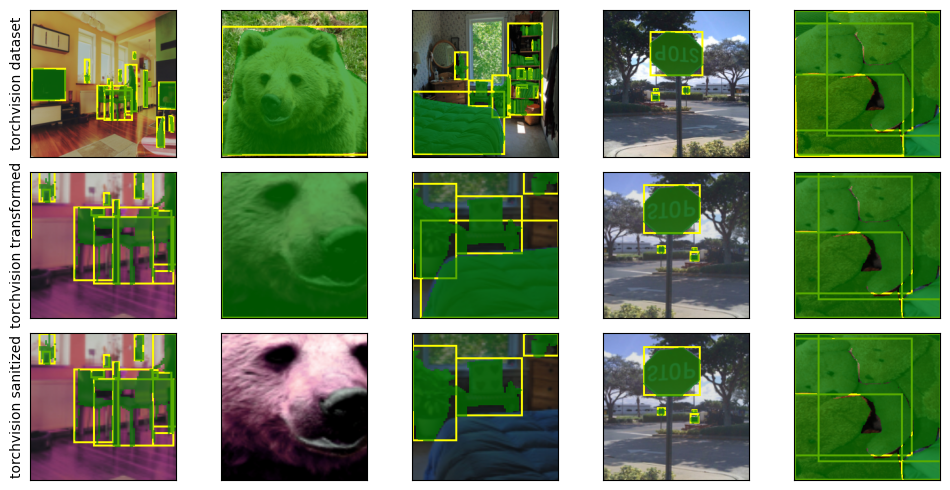

In [10]:
plot(
    [[torchvision_dataset[i] for i in range(5)], torchvision_batch, sanitized_torchvision_batch],
    row_title=["torchvision dataset", "torchvision transformed", "torchvision sanitized"],
)

### Torchaug and Torchvision

/home/jdenize/miniconda3/envs/torchaug/lib/python3.11/site-packages/torchvision/utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")
/home/jdenize/miniconda3/envs/torchaug/lib/python3.11/site-packages/torchvision/utils.py:303: UserWarning: masks doesn't contain any mask. No mask was drawn
  warnings.warn("masks doesn't contain any mask. No mask was drawn")
/home/jdenize/miniconda3/envs/torchaug/lib/python3.11/site-packages/torchvision/utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")
/home/jdenize/miniconda3/envs/torchaug/lib/python3.11/site-packages/torchvision/utils.py:303: UserWarning: masks doesn't contain any mask. No mask was drawn
  warnings.warn("masks doesn't contain any mask. No mask was drawn")


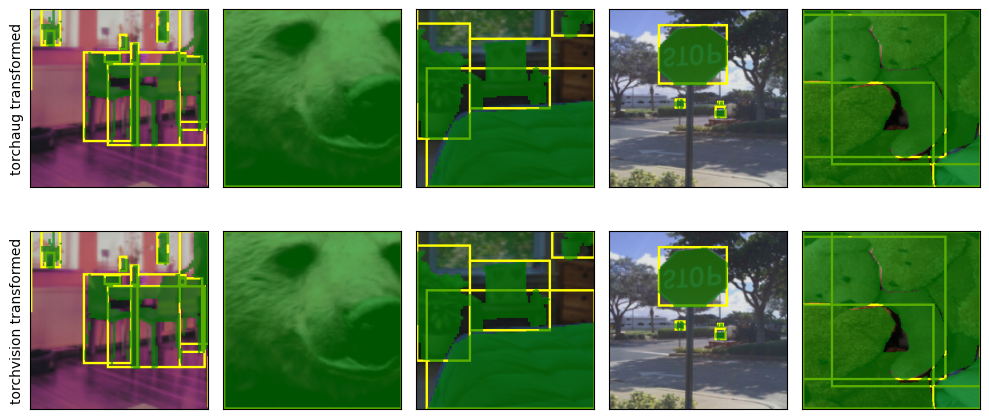

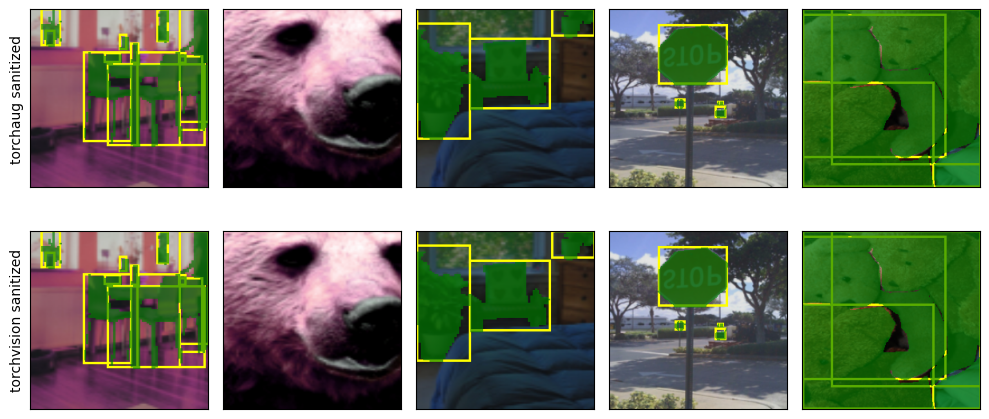

In [11]:
plot(
    [torchaug_transformed_batch_uncollated, torchvision_batch],
    row_title=["torchaug transformed", "torchvision transformed"],
)
plot(
    [sanitized_torchaug_batch_uncollated, sanitized_torchvision_batch],
    row_title=["torchaug sanitized", "torchvision sanitized"],
)